### 06 Colab 環境での Gradio UI の実装
#### 機能
- Google Colab 環境で Gradio を立ち上げする。
- Gradio UI に PDFファイルをドラッグアンドドロップで入力する。
- PDF ファイルが入力されたら、markdown に変換・前処理し、PDF の内容の先頭1000行を表示する。
- PDF の内容表示は、画面をスクロールして、表示内容の全文を確認できるようにする。
- Gradio UI にチャットインターフェース（ユーザ入力 / AI 回答）を設ける。
- AI チャットは、マルチターンチャット可能とする。
- ユーザ入力 / AI 回答とも、画面をスクロールして、会話履歴含めた全文を確認できるようにする。

#### 環境・要件
- Google Colab に Ollama をセットアップ
- ChatOllama で LLM に接続
- LangGraph によるLLMのメモリ管理
- LangGraph/LangChain によるチャット
- データの前処理
  - markdown に変換（MarkItDown を使用）
  - Unicode正規化 (NFKC), 1文字行ブロックの除去, 空行圧縮

**必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後勝ちで依存関係が壊れるリスクがある。
- NOTE: Colab では uv ではなく pip を使う。
> uv は依存解決の過程で numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [ ]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
# Pythonのリストとして定義することで、Pylanceの警告を防ぎ、可読性を高める。

# fmt: off
pkgs = [
    "ollama", "langchain-ollama",
    "langchain>=1.2.8", "langchain-core>=1.2.8", "langgraph>=1.0.7",
    "markitdown[all]", "gradio",
]
# fmt: on

# リストを結合して pip に渡す
# magic command内で {変数} を使うと展開される機能を利用
%pip install -U -q {" ".join(pkgs)}

**Google Colab に Ollama をセットアップ**
- Ollama のインストール, 起動, モデルのダウンロードを行う。
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [ ]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time
import ollama  # type: ignore

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)


def ollama_pull(model: str) -> None:
    """Ollama モデルをダウンロードし、進捗をインライン表示する。

    NOTE: ollama pull のプログレスバーは Colab で文字化けするため、
          Python API 経由でステータスのみ表示する。
    """
    for progress in ollama.pull(model, stream=True):
        status = progress.get("status", "")
        total = progress.get("total") or 0
        completed = progress.get("completed") or 0
        if total:
            line = f"{status}: {completed / total:.0%}"
        else:
            line = status
        print(f"\r{line:<60}", end="", flush=True)
    print(f"\n{model}: Done!")


# AI エージェントにはツールコール対応モデルが必要。
model_name = "gpt-oss:20b"
ollama_pull(model_name)
!ollama show {model_name}

Selecting previously unselected package zstd.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
Done!
  Model
    architecture        gemma3     
    parameters          999.89M    
    context length      32768      
    embedding length    1152       
    quantization        Q4_0       

  Capabilities
    completion    

  Parameters
    stop           "<end_

**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [ ]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gpt-oss:20b",
    num_ctx=16384,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning=None,
)

**LangGraph によるLLMのメモリ管理**
- chat_node で、LLM を呼び出した際の処理を設定。
> 今回は人間のプロンプトを LLM に入力して、LLM から応答を取得する処理。
- LangGraph のグラフを構築し、ノードとエッジを設定し、グラフを compile する。
> 今回は単純だが、各処理をつなげて自動化させる場合に効果を発揮する。
- InMemorySaver を使用して、LLM との会話をメモリに保存させる。
> LLM とのチャット履歴が保持されるようになる。
- 作成したグラフを図示する。

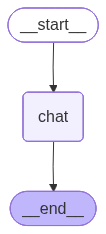

In [4]:
# LangGraph によるメモリ付きチャットグラフの構築
# InMemorySaver を使って、スレッド（thread_id）ごとに会話履歴を保持する
from langgraph.graph import StateGraph, MessagesState, START, END  # type: ignore
from langgraph.checkpoint.memory import InMemorySaver  # type: ignore
from IPython.display import Image, display


# チャットノード：現在の会話履歴を LLM に送信し、返答を生成
def chat_node(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}


# グラフの構築
graph = StateGraph(MessagesState)
graph.add_node("chat", chat_node)
graph.add_edge(START, "chat")
graph.add_edge("chat", END)

# InMemorySaver：スレッドごとに会話履歴をインメモリで保持
memory = InMemorySaver()
app = graph.compile(checkpointer=memory)

# 構築したグラフを図示
display(Image(app.get_graph().draw_mermaid_png()))

**データの前処理関数の定義**
- MarkItDown で PDF → markdown に変換する。
- 前処理: Unicode正規化 (NFKC), 1文字行ブロックの除去, 空行圧縮を行う。
- 詳細は [04_AI_Embedding_RAG.ipynb](04_AI_Embedding_RAG.ipynb) を参照。

In [ ]:
# PDF → markdown 変換 + 前処理（Unicode正規化, ゴミ除去, 空行圧縮）
# 詳細は 04_AI_Embedding_RAG.ipynb を参照
import re
import unicodedata
from markitdown import MarkItDown  # type: ignore


def clean_pdf_text(text: str) -> str:
    """PDF 抽出テキストの汎用クリーニングを行う。

    1. 1文字行が 3 行以上連続するブロックを除去（図表・縦書き由来のゴミ）
    2. 連続する空行を 2 つまでに圧縮
    """
    text = re.sub(
        r"(^[^\S\n]*\S[^\S\n]*$\n?){3,}",
        "\n",
        text,
        flags=re.MULTILINE,
    )
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()


def process_pdf(filepath: str) -> str:
    """PDF ファイルを markdown に変換し、前処理を行う。"""
    md = MarkItDown()
    result = md.convert(filepath)
    text = result.text_content

    # Unicode 正規化 (NFKC)
    text = unicodedata.normalize("NFKC", text)

    # クリーニング
    text = clean_pdf_text(text)
    return text


print("process_pdf 関数を定義しました。")

**Gradio UI の実装**
- 左カラム: PDF ファイルのドラッグ＆ドロップ入力と、変換後テキストの表示（先頭1000行、スクロール可能）
- 右カラム: マルチターン対応のチャットインターフェース（会話履歴スクロール可能）
- PDF をアップロードすると、新しい会話スレッドが開始される。
- `share=True` で Colab 環境からでもパブリック URL でアクセス可能。

In [7]:
# Gradio UI: PDF アップロード + AI チャット
import uuid
import gradio as gr  # type: ignore
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore

# セッション状態: PDF テキストとスレッド ID を保持する
session = {
    "pdf_text": "",
    "thread_id": str(uuid.uuid4()),
    "first_message": True,
}


def on_pdf_upload(filepath: str) -> tuple[str, list]:
    """PDF アップロード時: markdown 変換・前処理し、先頭1000行を返す。
    同時にチャット履歴をリセットし、新しい会話スレッドを開始する。
    """
    if filepath is None:
        session["pdf_text"] = ""
        return "PDF ファイルをドラッグ＆ドロップしてください。", []

    text = process_pdf(filepath)
    session["pdf_text"] = text
    session["thread_id"] = str(uuid.uuid4())
    session["first_message"] = True

    # 先頭1000行を表示用に切り出す
    lines = text.split("\n")[:1000]
    display_text = "\n".join(lines)
    if len(text.split("\n")) > 1000:
        display_text += "\n\n... (1000行以降は省略)"

    return display_text, []  # チャット履歴もリセット


def respond(message: str, chat_history: list) -> tuple[str, list]:
    """ユーザのメッセージを LLM に送信し、応答をチャット履歴に追加する。"""
    if not message.strip():
        return "", chat_history

    config = {"configurable": {"thread_id": session["thread_id"]}}
    messages = []

    # 最初のメッセージ時にシステムプロンプトを設定する
    if session["first_message"]:
        system_content = "日本語で回答してください。"
        if session["pdf_text"]:
            # コンテキスト長に収まるよう、PDF テキストを制限する
            pdf_excerpt = session["pdf_text"][:3000]
            system_content += (
                "\n\n以下はアップロードされた PDF の内容です。"
                "この内容に基づいて回答してください:\n\n"
                f"{pdf_excerpt}"
            )
        messages.append(SystemMessage(content=system_content))
        session["first_message"] = False

    messages.append(HumanMessage(content=message))

    response = app.invoke({"messages": messages}, config=config)
    bot_reply = response["messages"][-1].content

    # Gradio の messages フォーマット（role/content 辞書）で履歴に追加
    chat_history.append({"role": "user", "content": message})
    chat_history.append({"role": "assistant", "content": bot_reply})
    return "", chat_history


# --- Gradio UI の構築 ---
with gr.Blocks(title="PDF チャットアシスタント") as demo:
    gr.Markdown("### PDF チャットアシスタント")

    with gr.Row():
        # 左カラム: PDF アップロード + 内容表示
        with gr.Column(scale=1):
            pdf_input = gr.File(
                label="PDF ファイルをドラッグ＆ドロップ",
                file_types=[".pdf"],
                type="filepath",
            )
            pdf_display = gr.Textbox(
                label="PDF 内容（先頭1000行）",
                lines=25,
                max_lines=25,
                interactive=False,
            )

        # 右カラム: チャットインターフェース
        with gr.Column(scale=1):
            chatbot = gr.Chatbot(
                label="AI チャット",
                height=400,
            )
            msg_input = gr.Textbox(
                label="メッセージを入力",
                placeholder="質問を入力してください...",
                lines=2,
            )
            send_btn = gr.Button("送信", variant="primary")

    # イベントハンドラの設定
    pdf_input.change(
        on_pdf_upload,
        inputs=pdf_input,
        outputs=[pdf_display, chatbot],
    )
    send_btn.click(
        respond,
        inputs=[msg_input, chatbot],
        outputs=[msg_input, chatbot],
    )
    msg_input.submit(
        respond,
        inputs=[msg_input, chatbot],
        outputs=[msg_input, chatbot],
    )

# Colab 環境では share=True でパブリック URL を生成する
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://19aa702d0d5fa3bf33.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
demo.close()